In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from preprocessing import market_prepro
import time

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                            )

Now that we have Spencer's data importer lets make a driver that pulls in the data and training the model

SUDO CODE:

1. call data importer

2. restructure the dataset based on number of days desired [function written]

3. train model with training data

4. test model

5. return metrics

In [2]:
# st = "Stocks"
st = "ETFs"

#Input stock name
sn = "aadr" 
# f = r'D:\Desktop\College Spring 2023\machineLearning\project\coding\data'
f = r'H:\My Drive\stockMarket_data'
X_train, X_test, T_train, T_test = market_prepro(f,st,sn)

print(X_train.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1044 entries, 2010-07-21 to 2015-09-14
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1044 non-null   float64
 1   High              1044 non-null   float64
 2   Low               1044 non-null   float64
 3   Volume            1044 non-null   float64
 4   High-Low          1044 non-null   float64
 5   Close-Open        1044 non-null   float64
 6   Day_date          1044 non-null   int32  
 7   Month             1044 non-null   int32  
 8   Year              1044 non-null   int32  
 9   near_end_quarter  1044 non-null   int64  
 10  Day               1044 non-null   int64  
dtypes: float64(6), int32(3), int64(2)
memory usage: 85.6 KB
None


In [3]:
def structure_timeseries_features(df,offset_back, offset_for,exclude):
    '''
    This takes a dataframe and creates new columns that contain the data from
    previous days so that time series forecasting can occur.

    INPUTS:
        df - dataframe: input data

        offset - int: the number of days to go back. This creates this many
                        new columns

        exclude - list str: list of columns to exclude from the time series 
                            expansion

    OUTPUTS:
        df_out - dataframe: dataframe with new columns
    '''

    df_out = pd.DataFrame() 

    for cc in df.columns.values:
        if (cc not in exclude):
            for ii in range(offset_back):
                col_name = (cc+"_m"+str(ii+1))

                df_out[col_name] = df[cc].shift(ii+1)


    df_out = df_out.iloc[offset_back:-offset_for,:]

    return df_out

def structure_timeseries_targets(df,offset_back, offset_for):
    '''
    companion function to remove the first few days of targets to make sure
    the sizes match between features and targets.

    INPUTS:
        df - dataframe: input data targets.

    OUTPUTS:
        df_out - dataframe: dataframe with rows removed

    '''
    # df_out = df.iloc[offset:]

    df_out = pd.DataFrame() 

    # for cc in df.columns.values:
    for ii in range(offset_for):
        col_name = (df.name+"_p"+str(ii))

        df_out[col_name] = df.shift(-(ii))


    df_out = df_out.iloc[offset_back:-offset_for,:]

    return df_out

# ff = X_train.copy()
# tt = T_train.copy()



# df_ff = structure_timeseries_features(ff,2,5, ['Day_date','Month','Year'])
# df_tt = structure_timeseries_targets(tt,2,5)


In [14]:
from sklearn.metrics import (r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                            )


def modeldriver(mdl, n_days_back, n_days_for, f, st, sn):
    '''
    This function takes a model, imports the data, trains the model, and tests 
    the model

    INPUTS:
        mdl -  the model to test

        n_days_back - int: the number of days to go back to use as features

        n_days_for - int: the number of days to predict into the future

        f - str: filepath to the stock

        st - str: stock type

        sn - str: stock name
    OUTPUTS:
        NONE:
    '''

    exclude_col = ['Day_date','Month','Year']

    X_train, X_test, T_train, T_test = market_prepro(f,st,sn)

    X_train = structure_timeseries_features(X_train,
                                            n_days_back, 
                                            n_days_for, 
                                            exclude_col,
                                            )
    X_test = structure_timeseries_features(X_test,
                                           n_days_back, 
                                           n_days_for, 
                                           exclude_col,
                                           )
    T_train =  structure_timeseries_targets(T_train,
                                            n_days_back,
                                            n_days_for,
                                            )
    T_test =  structure_timeseries_targets(T_test,
                                            n_days_back,
                                            n_days_for,
                                            )
    
    print(X_train.shape,X_test.shape)
    data = {'X_train': X_train, 
            'X_test': X_test, 
            'T_train': T_train, 
            'T_test':T_test}
    

    mdl.fit(X_train,T_train)

    y_train = mdl.predict(X_train)
    y_test = mdl.predict(X_test)

    y_train = pd.DataFrame(y_train,
                           columns=T_train.columns.values,
                           index=T_train.index
                           )
    y_test = pd.DataFrame(y_test,
                          columns=T_test.columns.values,
                          index=T_test.index
                          )

    score_train = mdl.score(X_train,T_train)
    score_test = mdl.score(X_test,T_test)

    test_mape = mean_absolute_percentage_error(data['T_test'],y_test, multioutput='raw_values')

    print('Test MAPE(%) ', test_mape*100)

    return y_train, y_test, data

def modeldriverCV(mdl, n_days_back, n_days_for, f, st, sn, mdl_params):

    '''
    This function takes a model, imports the data, trains the model, and tests 
    the model

    INPUTS:
        mdl -  the model to test

        n_days_back - int: the number of days to go back to use as features

        n_days_for - int: the number of days to predict into the future

        f - str: filepath to the stock

        st - str: stock type

        sn - str: stock name
        
        mdl_params - paramaters to be used in grid search
    OUTPUTS:
        NONE:
    '''
    start_time = time.time()
    exclude_col = ['Day_date','Month','Year']
    best_params={}
    best_scores={}
    test_mape={}
    for k in n_days_back:
        for kk in n_days_for:
            X, T = market_prepro(f,st,sn,verbose=False,splitdata=False)
            # print(X.shape,T.shape)
            X = structure_timeseries_features(X,
                                                    k, 
                                                    kk, 
                                                    exclude_col,
                                                    )

            T =  structure_timeseries_targets(T,
                                                    k,
                                                    kk,
                                                    )
            # print(X.shape,T.shape)
            data = {'X': X, 
                    'T':T}
            
            tscv = TimeSeriesSplit(n_splits = 5)
            mdl_cv = GridSearchCV(mdl, cv=tscv,
                                  param_grid=mdl_params)
            mdl_cv.fit(X,T)
            # print(mdl_cv.best_params_)
            # print(mdl_cv.best_score_)
   
            best_params[k,kk]=mdl_cv.best_params_
            best_scores[k,kk]=mdl_cv.best_score_
            y = mdl_cv.predict(X)


            y = pd.DataFrame(y,
                                   columns=T.columns.values,
                                   index=T.index
                                   )           

            test_mape[k,kk] = mean_absolute_percentage_error(data['T'],y, multioutput='raw_values')*100

            
            
            
        end_time = time.time()
        total_time= end_time-start_time
        print(f'Run time {total_time}s')
     
    # print(best_params)
    # print(best_scores)
    # print('Test MAPE(%) ', test_mape)#*100)
        



    # score = mdl_cv.score(X,T)
    
    return best_params, best_scores, test_mape

In [15]:
from sklearn.linear_model import Ridge

# mdl_r = Ridge(alpha=0.01)
# y_train, y_test, score_train, score_test = modeldriver(mdl_r, 5, 1, f, st, sn)

# # plt.scatter(y_train,T_train.iloc[5:])

# plt.plot(range(0,len(T_train.iloc[5:])),T_train.iloc[5:])
# plt.scatter(range(0,len(T_train.iloc[5:])),y_train,c='r')

parameters_mdl = {'alpha':np.linspace(.001,10)}

mdl_r_grido = Ridge()
n_for=[1,2,3,4,5,6,7]
n_aft=[1,2,3,4,5]
modeldriverCV(mdl_r_grido, n_for, n_aft, f, st, sn, parameters_mdl)

Run time 12.884061813354492s
Run time 26.435703992843628s
Run time 40.51663041114807s
Run time 55.641613245010376s
Run time 70.97491097450256s
Run time 86.60152387619019s
Run time 102.6438422203064s


({(1, 1): {'alpha': 0.6131836734693878},
  (1, 2): {'alpha': 0.6131836734693878},
  (1, 3): {'alpha': 1.0213061224489797},
  (1, 4): {'alpha': 1.0213061224489797},
  (1, 5): {'alpha': 1.0213061224489797},
  (2, 1): {'alpha': 1.8375510204081633},
  (2, 2): {'alpha': 3.470040816326531},
  (2, 3): {'alpha': 3.8781632653061227},
  (2, 4): {'alpha': 3.470040816326531},
  (2, 5): {'alpha': 3.061918367346939},
  (3, 1): {'alpha': 2.857857142857143},
  (3, 2): {'alpha': 3.8781632653061227},
  (3, 3): {'alpha': 4.490346938775511},
  (3, 4): {'alpha': 3.8781632653061227},
  (3, 5): {'alpha': 3.8781632653061227},
  (4, 1): {'alpha': 3.061918367346939},
  (4, 2): {'alpha': 5.714714285714287},
  (4, 3): {'alpha': 5.306591836734695},
  (4, 4): {'alpha': 4.694408163265307},
  (4, 5): {'alpha': 4.898469387755103},
  (5, 1): {'alpha': 4.0822244897959195},
  (5, 2): {'alpha': 5.714714285714287},
  (5, 3): {'alpha': 5.918775510204083},
  (5, 4): {'alpha': 5.510653061224491},
  (5, 5): {'alpha': 5.7147142

In [17]:
from sklearn.linear_model import Lasso

# mdl_l = Lasso(alpha=0.01)

# y_train, y_test, score_train, score_test = modeldriver(mdl_l, 5, f, st, sn)

# plt.plot(range(0,len(T_train.iloc[5:])),T_train.iloc[5:])
# plt.scatter(range(0,len(T_train.iloc[5:])),y_train,c='r')

parameters_mdl = {'alpha':np.linspace(.001,1)}
mdl_r_grido = Lasso()
n_for=[1,2,3,4,5,6,7]
n_aft=[1,2,3,4,5]
modeldriverCV(mdl_r_grido, n_for, n_aft,f, st, sn, parameters_mdl)

C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.127e+01, tolerance: 7.463e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.164e-01, tolerance: 1.935e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Run time 13.935594320297241s


C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.173e+00, tolerance: 1.047e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.885e+01, tolerance: 1.974e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Run time 36.502846240997314s


C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.400e+01, tolerance: 1.042e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.652e+01, tolerance: 1.968e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Run time 64.32537698745728s


C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.481e-01, tolerance: 8.032e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e+01, tolerance: 1.038e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Run time 96.49597501754761s


C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.413e-01, tolerance: 8.404e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.538e+01, tolerance: 1.049e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Run time 132.04213857650757s


C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.700e+00, tolerance: 8.258e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.547e+01, tolerance: 1.044e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Run time 171.74412035942078s


C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.974e+00, tolerance: 8.097e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.547e+00, tolerance: 1.951e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Run time 215.53558707237244s


({(1, 1): {'alpha': 0.001},
  (1, 2): {'alpha': 0.001},
  (1, 3): {'alpha': 0.001},
  (1, 4): {'alpha': 0.001},
  (1, 5): {'alpha': 0.001},
  (2, 1): {'alpha': 0.001},
  (2, 2): {'alpha': 0.021387755102040818},
  (2, 3): {'alpha': 0.021387755102040818},
  (2, 4): {'alpha': 0.021387755102040818},
  (2, 5): {'alpha': 0.021387755102040818},
  (3, 1): {'alpha': 0.021387755102040818},
  (3, 2): {'alpha': 0.021387755102040818},
  (3, 3): {'alpha': 0.021387755102040818},
  (3, 4): {'alpha': 0.021387755102040818},
  (3, 5): {'alpha': 0.021387755102040818},
  (4, 1): {'alpha': 0.021387755102040818},
  (4, 2): {'alpha': 0.021387755102040818},
  (4, 3): {'alpha': 0.021387755102040818},
  (4, 4): {'alpha': 0.021387755102040818},
  (4, 5): {'alpha': 0.021387755102040818},
  (5, 1): {'alpha': 0.021387755102040818},
  (5, 2): {'alpha': 0.021387755102040818},
  (5, 3): {'alpha': 0.021387755102040818},
  (5, 4): {'alpha': 0.021387755102040818},
  (5, 5): {'alpha': 0.021387755102040818},
  (6, 1): {'alp

In [14]:
from sklearn.linear_model import (Ridge,
                                  Lasso,
                                )

from sklearn.svm import (SVR,
                         )



n_days_back = 5
n_days_for = 5

print('Ridge')
mdl_r = Ridge(alpha=1)

y_train, y_test, data_out = modeldriver(mdl_r, n_days_back, n_days_for, f, st, sn)

print('Lasso')
mdl_l = Lasso(alpha=0.01)

y_train, y_test, data_out = modeldriver(mdl_l, n_days_back, n_days_for, f, st, sn)




Ridge
(1034, 40) (511, 40)
Test MAPE(%)  [0.90745116 1.24368434 1.5105012  1.72887082 1.92042668]
Lasso
(1034, 40) (511, 40)
Test MAPE(%)  [0.8935919  1.22061237 1.48683446 1.7135024  1.90054528]


In [10]:
print(np.shape(y_test))

(511, 5)


(511, 5)


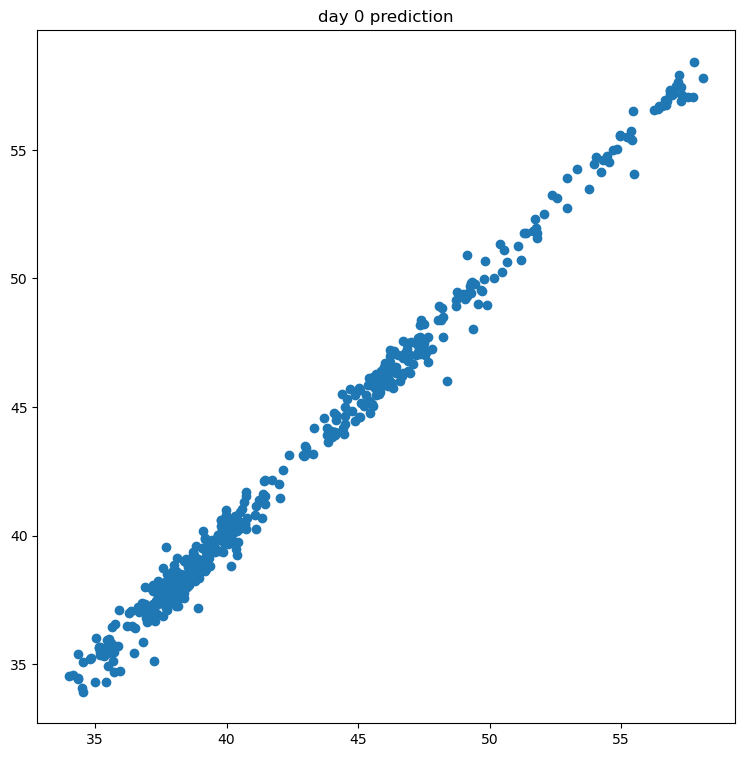

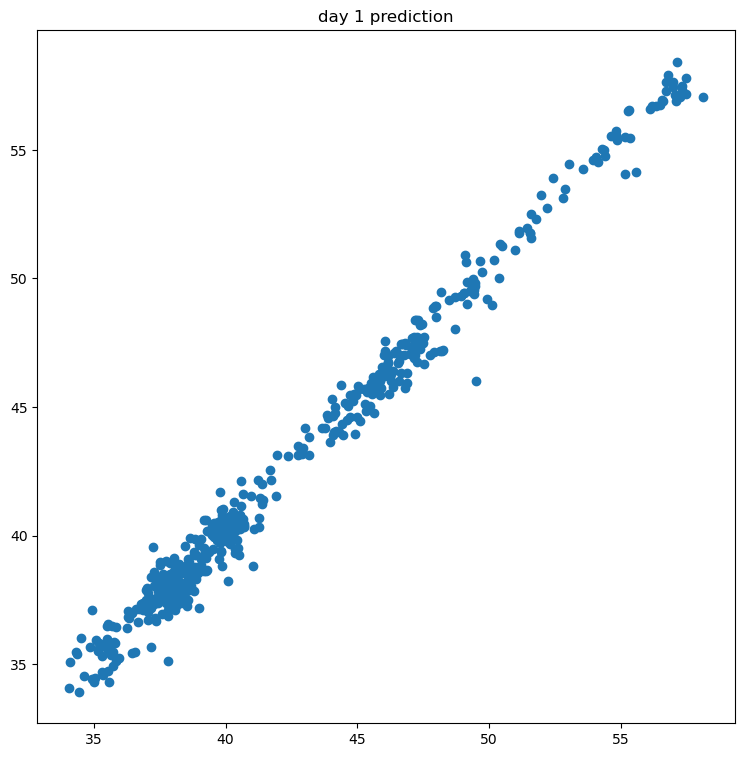

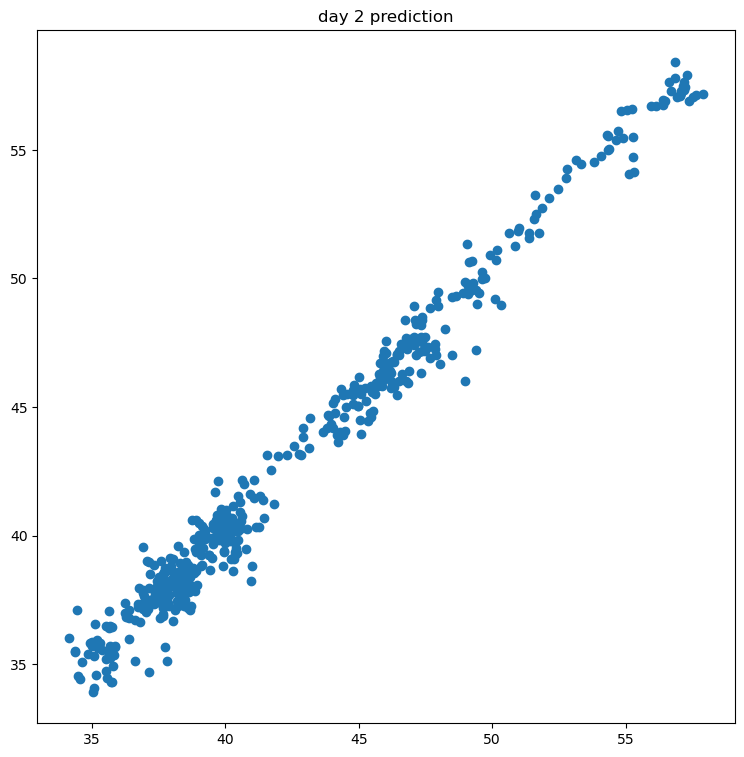

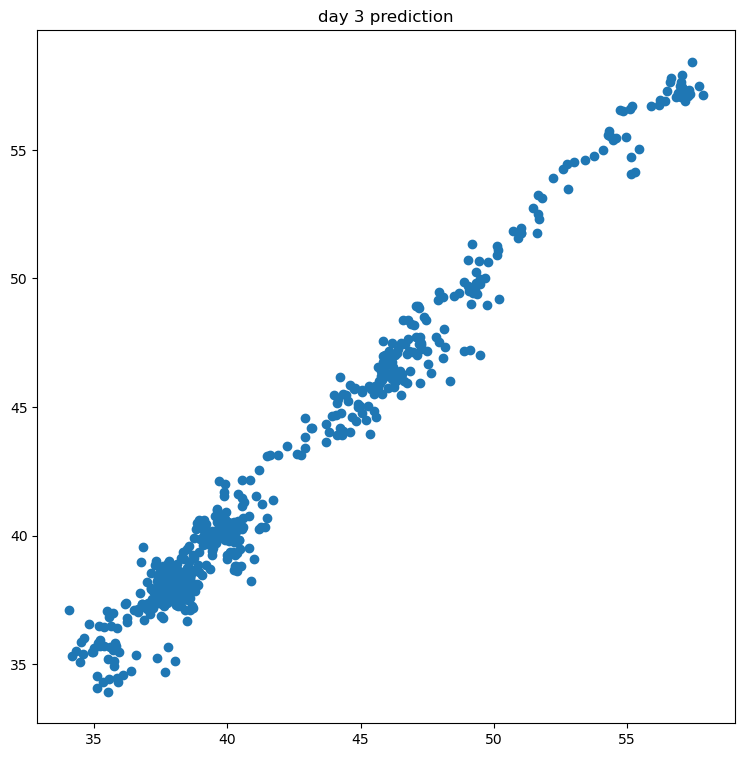

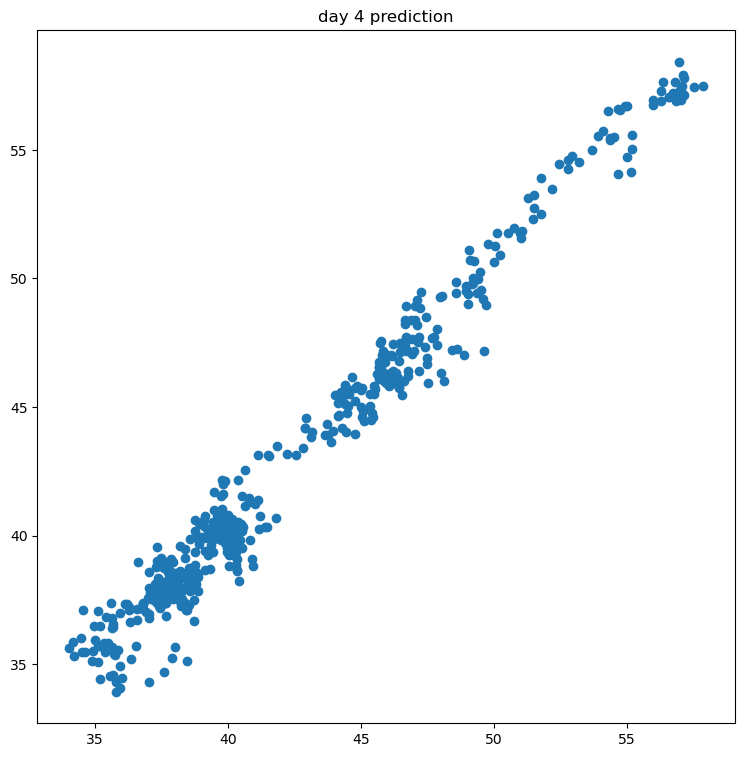

In [14]:
plotlen = 1000

x = range(0,plotlen)

print(np.shape(y_test))
for ii in range(0,np.shape(y_test)[1]):
    y_true = data_out['T_test'].iloc[0:plotlen,ii]
    y_test_plt = y_test.iloc[0:plotlen,ii]
    plt.figure(figsize=(9,9))
    plt.scatter(y_test_plt,y_true,label='true')
    plt.title('day '+ str(ii) + ' prediction')